# 🔑 Homework Solution Key: Diffusion Models — Cosine Schedule on Moons

---

### Task 1: Load and plot the Moons dataset

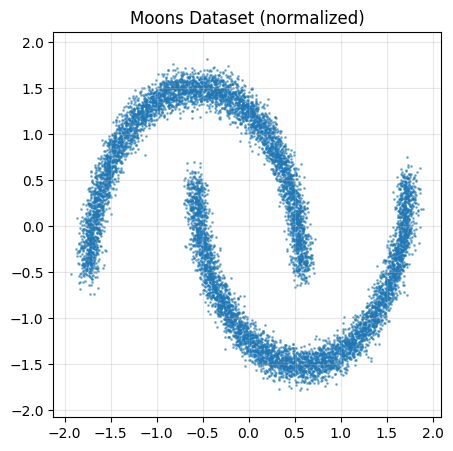

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_moons

torch.manual_seed(42)
np.random.seed(42)
device = "cpu"

# Generate Moons dataset
data, _ = make_moons(n_samples=10000, noise=0.05)
data = (data - data.mean(axis=0)) / data.std(axis=0)
dataset = torch.tensor(data, dtype=torch.float32)

plt.figure(figsize=(5, 5))
plt.scatter(dataset[:, 0], dataset[:, 1], s=1, alpha=0.5)
plt.title("Moons Dataset (normalized)")
plt.axis("equal"); plt.grid(alpha=0.3)
plt.show()

### Model & helpers (copied from tutorial)

In [3]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-np.log(10000) * torch.arange(half, dtype=torch.float32) / half).to(t.device)
        args = t.float().unsqueeze(-1) * freqs.unsqueeze(0)
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

class SimpleNoisePredictor(nn.Module):
    def __init__(self, data_dim=2, hidden=128, time_dim=64):
        super().__init__()
        self.time_embed = SinusoidalEmbedding(time_dim)
        self.net = nn.Sequential(
            nn.Linear(data_dim + time_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, data_dim),
        )
    def forward(self, x_t, t):
        t_emb = self.time_embed(t)
        return self.net(torch.cat([x_t, t_emb], dim=-1))

def q_sample(x0, t, alpha_bar):
    noise = torch.randn_like(x0)
    sqrt_ab = torch.sqrt(alpha_bar[t]).unsqueeze(-1)
    sqrt_one_minus_ab = torch.sqrt(1 - alpha_bar[t]).unsqueeze(-1)
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise, noise

@torch.no_grad()
def sample_ddpm(model, n_samples, T, betas, alphas, alpha_bar):
    x = torch.randn(n_samples, 2).to(device)
    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, dtype=torch.long, device=device)
        eps_pred = model(x, t_batch)
        coeff1 = 1.0 / torch.sqrt(alphas[t])
        coeff2 = betas[t] / torch.sqrt(1.0 - alpha_bar[t])
        x = coeff1 * (x - coeff2 * eps_pred)
        if t > 0:
            x = x + torch.sqrt(betas[t]) * torch.randn_like(x)
    return x

### Task 2: Cosine noise schedule

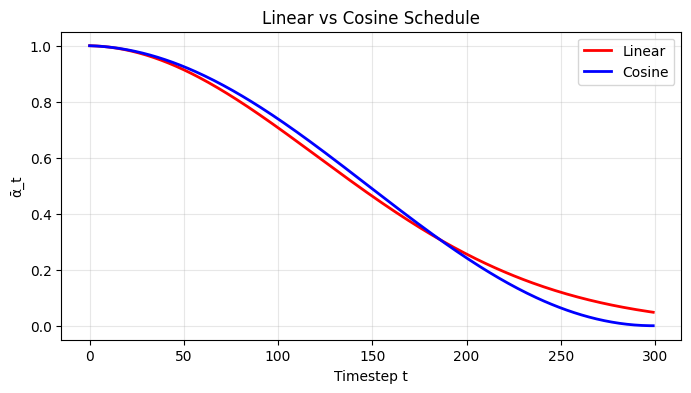

In [4]:
T = 300

# --- Linear schedule ---
betas_linear = torch.linspace(1e-4, 0.02, T)
alphas_linear = 1.0 - betas_linear
alpha_bar_linear = torch.cumprod(alphas_linear, dim=0)

# --- Cosine schedule (Nichol & Dhariwal 2021) ---
s = 0.008
steps = torch.arange(T + 1, dtype=torch.float64)
f = torch.cos(((steps / T) + s) / (1 + s) * torch.pi / 2) ** 2
alpha_bar_cosine = (f / f[0])[1:]

# Derive betas from alpha_bar
alpha_bar_cosine_shifted = torch.cat([torch.tensor([1.0], dtype=torch.float64), alpha_bar_cosine[:-1]])
betas_cosine = (1 - alpha_bar_cosine / alpha_bar_cosine_shifted).clamp(max=0.999)
betas_cosine = betas_cosine.float()
alphas_cosine = (1.0 - betas_cosine)
alpha_bar_cosine = alpha_bar_cosine.float()

# Plot comparison
plt.figure(figsize=(8, 4))
plt.plot(alpha_bar_linear.numpy(), label="Linear", linewidth=2, color="red")
plt.plot(alpha_bar_cosine.numpy(), label="Cosine", linewidth=2, color="blue")
plt.xlabel("Timestep t"); plt.ylabel("ᾱ_t")
plt.title("Linear vs Cosine Schedule"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

### Task 3: Train with cosine schedule

Training with COSINE schedule...
  Epoch 20/100, Loss: 0.4586
  Epoch 40/100, Loss: 0.4259
  Epoch 60/100, Loss: 0.4142
  Epoch 80/100, Loss: 0.4234
  Epoch 100/100, Loss: 0.4109


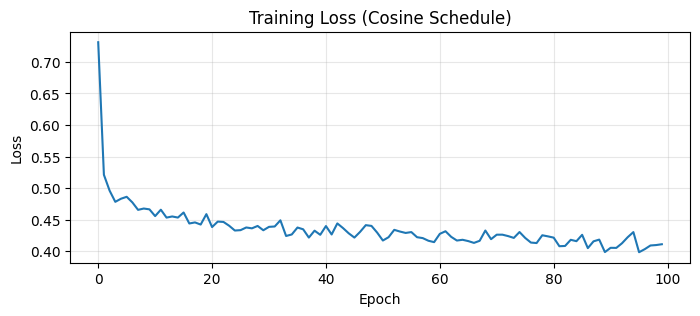

In [5]:
def train_model(dataset, T, betas, alphas, alpha_bar, n_epochs=100, batch_size=256, lr=1e-3):
    model = SimpleNoisePredictor().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(n_epochs):
        perm = torch.randperm(dataset.shape[0])
        epoch_loss, n = 0.0, 0
        for i in range(0, dataset.shape[0], batch_size):
            x0 = dataset[perm[i:i+batch_size]]
            bl = x0.shape[0]
            t = torch.randint(0, T, (bl,))
            x_t, noise = q_sample(x0, t, alpha_bar)
            loss = nn.functional.mse_loss(model(x_t, t), noise)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            epoch_loss += loss.item(); n += 1
        losses.append(epoch_loss / n)
        if (epoch+1) % 20 == 0:
            print(f"  Epoch {epoch+1}/{n_epochs}, Loss: {losses[-1]:.4f}")
    return model, losses

print("Training with COSINE schedule...")
model_cos, losses_cos = train_model(dataset, T, betas_cosine, alphas_cosine, alpha_bar_cosine)

plt.figure(figsize=(8, 3))
plt.plot(losses_cos); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training Loss (Cosine Schedule)"); plt.grid(alpha=0.3)
plt.show()

### Task 4: Sample and compare

Training with LINEAR schedule...
  Epoch 20/100, Loss: 0.4508
  Epoch 40/100, Loss: 0.4344
  Epoch 60/100, Loss: 0.4193
  Epoch 80/100, Loss: 0.4349
  Epoch 100/100, Loss: 0.4217


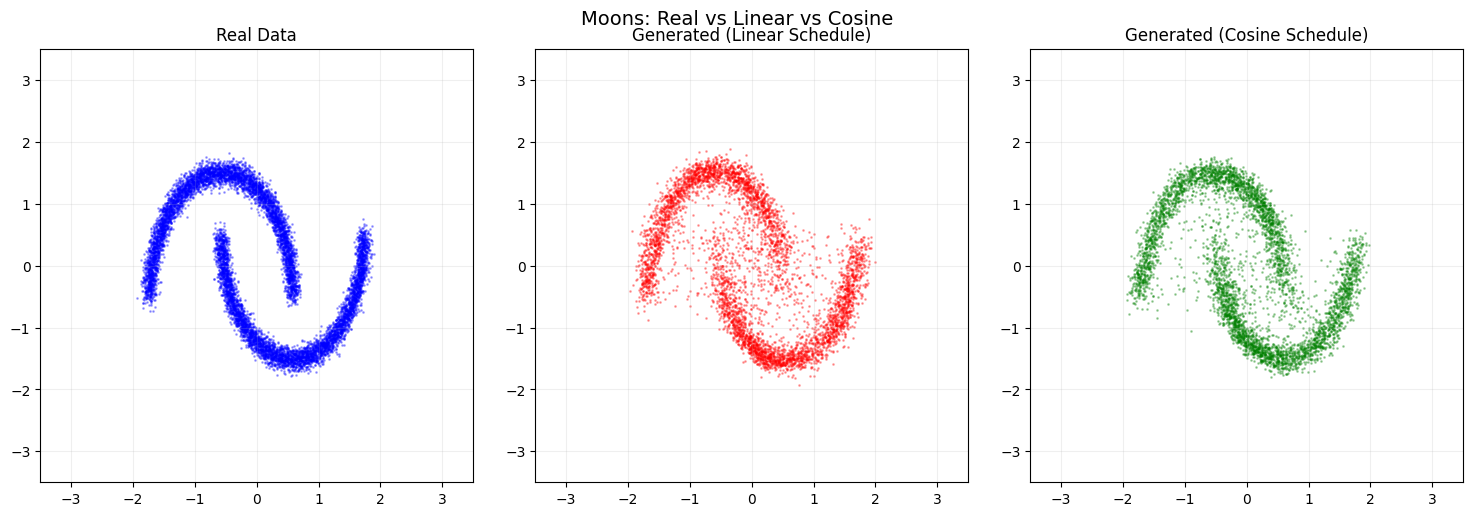

In [6]:
# Also train with linear schedule for comparison
print("Training with LINEAR schedule...")
model_lin, losses_lin = train_model(dataset, T, betas_linear, alphas_linear, alpha_bar_linear)

# Generate samples
samples_cos = sample_ddpm(model_cos, 5000, T, betas_cosine, alphas_cosine, alpha_bar_cosine)
samples_lin = sample_ddpm(model_lin, 5000, T, betas_linear, alphas_linear, alpha_bar_linear)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(dataset[:, 0], dataset[:, 1], s=1, alpha=0.3, c="blue")
axes[0].set_title("Real Data")

axes[1].scatter(samples_lin[:, 0].numpy(), samples_lin[:, 1].numpy(), s=1, alpha=0.3, c="red")
axes[1].set_title("Generated (Linear Schedule)")

axes[2].scatter(samples_cos[:, 0].numpy(), samples_cos[:, 1].numpy(), s=1, alpha=0.3, c="green")
axes[2].set_title("Generated (Cosine Schedule)")

for ax in axes:
    ax.set_xlim(-3.5, 3.5); ax.set_ylim(-3.5, 3.5)
    ax.set_aspect("equal"); ax.grid(alpha=0.2)

plt.suptitle("Moons: Real vs Linear vs Cosine", fontsize=14)
plt.tight_layout()
plt.show()

### Task 5: Short answer

**Sample answer:**

For this simple 2D dataset, both schedules produce reasonable results, and the difference may be small. The cosine schedule can help because the linear schedule wastes many timesteps at the end where the data is already pure noise, meaning the model doesn't learn useful denoising for those steps. The cosine schedule distributes the signal-to-noise ratio more evenly, giving the network meaningful gradients at every timestep. However, for very simple 2D data, the model has enough capacity to learn the distribution well regardless of schedule — the schedule difference matters more for higher-dimensional data like images (as shown in Nichol & Dhariwal 2021).